## Naive Bayes Bigrams Age Prediction ##

In [2]:
# import library
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import spacy
from collections import Counter

This bigram model code is provided by: https://github.com/twistedTightly/NLP-Age-Classification/blob/master/src/naive_bayes_bigrams_class_return_probs.py

In [3]:
#Method 1: Naive Bayes
#In main in this file is the final bag of words classifier where the classifier returns probabilities and we interpret them to get a final accuracy

df = pd.read_excel('../AgeProcessedData.xlsx')

def addLogProbs(logp, logq):
	if logp > logq:
		bigger = logp
		smaller = logq
	else:
		bigger = logq
		smaller = logp
	return bigger + math.log10(1 + math.pow(10, smaller - bigger))

class naive_bayes:
	def __init__(self, trainingData):
		#Set categories
		categories = ['10', '20', '30', '40']

		#Create data structures for word counts and category counts
		wordCounts = dict()
		categoryDocumentCounts = dict()
		categoryWordCounts = dict()
		wordProbs = dict()
		for category in categories:
			wordCounts[category] = dict()
			categoryDocumentCounts[category] = 0
			categoryWordCounts[category] = 0
			wordProbs[category] = dict()
		numDocuments = 0
		vocabSet = set()

		#Read through each line; count and divide
		for line in trainingData:
			words = line.rstrip().split()
	
			#Separate first element (category) from the rest of the words
			category = words[0]
			words = words[1:]

			#Process the category
			if category not in categories:
				continue
			categoryDocumentCounts[category] += 1
			numDocuments += 1

			#Count words
			for word in words:
				parts = word.split("/")

				#Parse to get the actual word
				if len(parts) != 3:
					continue
				word = parts[0]
				pos = parts[1]
				sentencePart = parts[2]
		
				if word not in wordCounts[category]:
					wordCounts[category][word] = 0

				wordCounts[category][word] += 1
				categoryWordCounts[category] += 1
				vocabSet.add(word)

			#Count bigrams
			prevWord = words[0].split("/")[0]
			for word in words[1:]:
				parts = word.split("/")
	
				#Parse to get the actual word
				if len(parts) != 3:
					continue
				word = parts[0]
				pos = parts[1]
				sentencePart = parts[2]

				bigram = prevWord + " " + word

				if bigram not in wordCounts[category]:
					wordCounts[category][bigram] = 0

				wordCounts[category][bigram] += 1
				categoryWordCounts[category] += 1
				vocabSet.add(bigram)

				prevWord = word
	
		#Set up smoothing
		delta = 5
		vocabSize = len(vocabSet)

		#Calculate probabilities for each category
		categoryProbs = dict()
		for category in categories:
			categoryProbs[category] = float(categoryDocumentCounts[category]) / numDocuments
		
		#Calculate probabilities for each word
		for category in categories:
			for word in wordCounts[category]:
				wordProbs[category][word] = ( float(wordCounts[category][word]) + delta ) / ( categoryWordCounts[category] + vocabSize*delta )

		#Calculate probabilities for unknown words
		unknownWordProb = dict()
		for category in categories:
			unknownWordProb[category] = float(delta) / ( categoryWordCounts[category] + vocabSize*delta )

		#Save relevant data structures
		self.wordProbs = wordProbs
		self.unknownWordProb = unknownWordProb
		self.categories = categories

	#Testing
	def decode(self, words):
		
		#Get relevant data structures
		wordProbs = self.wordProbs
		unknownWordProb = self.unknownWordProb
		categories = self.categories
		

		#Add up log probabilities for each word, for each category:
		thisLineLogProb = dict()
		for category in categories:
			thisLineLogProb[category] = 0
			for word in words:
				parts = word.split("/")

				#Parse to get the actual word
				if len(parts) != 3:
					continue
				word = parts[0]
				pos = parts[1]
				sentencePart = parts[2]

				#Increment probability
				if word in wordProbs[category]:
					thisWordProb = wordProbs[category][word]
				else:
					thisWordProb = unknownWordProb[category]
				thisLineLogProb[category] += math.log10(thisWordProb)

			#Count bigrams
			prevWord = words[0].split("/")[0]
			for word in words[1:]:
				parts = word.split("/")
	
				#Parse to get the actual word
				if len(parts) != 3:
					continue
				word = parts[0]
				pos = parts[1]
				sentencePart = parts[2]

				bigram = prevWord + " " + word

				#Increment probability
				if bigram in wordProbs[category]:
					thisWordProb = wordProbs[category][bigram]
				else:
					thisWordProb = unknownWordProb[category]
				thisLineLogProb[category] += math.log10(thisWordProb)
		
		#Get log sum of the 4 log probabilities
		runningLogSum = thisLineLogProb[categories[0]]
		for category in categories[1:]:
			runningLogSum = addLogProbs(runningLogSum, thisLineLogProb[category])
		totalLogSum = runningLogSum
		
		#Construct 4-tuple to be returned of the probability of each category
		probsToReturn = []
		for category in categories:
			thisLogProb = thisLineLogProb[category] - totalLogSum
			thisProb = math.pow(10, thisLogProb)
			probsToReturn.append(thisProb)

		return probsToReturn


if __name__ == "__main__":
	#Set filenames
	trainFilename = "../all_posts_train.txt"
	testFilename = "../PosComments.txt"
    

	#Read in training file
	trainFile = open(trainFilename, 'r')
	trainData = trainFile.readlines()
	trainFile.close()

	#Create naive bayes classifier
	naive_bayes = naive_bayes(trainData)

	#Read in testing file
	testFile = open(testFilename, 'r')
	testData = testFile.readlines()
	testFile.close()

	numCorrect = 0
	numIncorrect = 0


predictedCategories = []  # Create a list to store predicted categories

for line in testData:
    words = line.rstrip().split()

    # Separate first element (category) from the rest of the words
    actualCategory = words[0]
    words = words[1:]

    probs = naive_bayes.decode(words)

    winningIndex = probs.index(max(probs))
    winningCategory = naive_bayes.categories[winningIndex]

    # Append the winning category to the list
    predictedCategories.append(winningCategory)


In [4]:
# Add the predicted categories to the DataFrame
df['PredictedCategory'] = predictedCategories

# Save the updated DataFrame to a new Excel file
df.to_excel('../AgeProcessedDataWithPredictions.xlsx', index=False)


In [5]:
# Final clean excel file
dfWithSentiment = pd.read_excel('../RobertaSentimental.xlsx')
dfWithSentiment['PredictedCategory'] = predictedCategories
dfWithSentiment.to_excel('SentimentalAge.xlsx')

In [6]:
df = pd.read_excel('../SentimentalAge.xlsx')


### Get the top10 most common words

In [7]:
# Load the English language small model of SpaCy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Extract positive and negative comments
positiveComments = " ".join(df[df['EmotionRoberta'] == 1]['Comment']).lower().split()
negativeComments = " ".join(df[df['EmotionRoberta'] == 0]['Comment']).lower().split()

# Remove stopwords and non-alphanumeric words using SpaCy's stopwords
positiveWords=[]
negativeWords=[]

for word in positiveComments:
    if word not in sw_spacy:
        positiveWords.append(word)

for word in negativeComments:
    if word not in sw_spacy:
        negativeWords.append(word)

# Get the most common words
positiveCount = Counter(positiveWords).most_common(10)
negativeCount = Counter(negativeWords).most_common(10)

print("Most common words in positive comments:", positiveCount)
print("Most common words in negative comments:", negativeCount)


Most common words in positive comments: [('maserati', 133), ('car', 127), ('like', 117), ('electric', 96), ('looks', 90), ('beautiful', 57), ('love', 55), ('ev', 54), ('v8', 45), ('better', 44)]
Most common words in negative comments: [('electric', 128), ('car', 125), ('maserati', 123), ('like', 105), ('cars', 64), ('ev', 55), ('looks', 54), ('sound', 52), ("it's", 51), ("don't", 46)]


### Get the top10 most common words without intersection

In [15]:
# Load the English language small model of SpaCy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Add "it's" to the stopwords set
sw_spacy.update(["it's", "-"])

# Extract positive and negative comments
positiveComments = " ".join(df[df['EmotionRoberta'] == 1]['Comment']).lower().split()
negativeComments = " ".join(df[df['EmotionRoberta'] == 0]['Comment']).lower().split()

# Remove stopwords and non-alphanumeric words using SpaCy's stopwords
positiveWords=[]
negativeWords=[]

for word in positiveComments:
    if word not in sw_spacy:
        positiveWords.append(word)

for word in negativeComments:
    if word not in sw_spacy:
        negativeWords.append(word)

# Get the most common words
positiveCount = Counter(positiveWords).most_common(10) #tuple ('maserati', 133),
negativeCount = Counter(negativeWords).most_common(10) 

# Extract just the words (without counts) from the common lists
positiveCountWords = set()
for word, count in positiveCount:
    positiveCountWords.add(word)

negativeCountWords= set()
for word,count in negativeCount:
    negativeCountWords.add(word)

# Identify words that are common to both positive and negative lists
intersectingWords = positiveCountWords.intersection(negativeCountWords)

# Remove the intersecting words from both lists
positiveCount = [(word, count) for word, count in positiveCount if word not in intersectingWords]
negativeCount = [(word, count) for word, count in negativeCount if word not in intersectingWords]

# Update the sets based on the cleaned common lists
positiveCountWords = set([word[0] for word in positiveCount]) #('beautiful',57)-> beautiful
negativeCountWords = set([word[0] for word in negativeCount])

# Continue extracting words from the overall most common lists
allPositiveCount = Counter(positiveWords).most_common()
allNegativeCount = Counter(negativeWords).most_common()

# Extract words from the common lists excluding those already identified
allPositiveCountWords = [word[0] for word in allPositiveCount if word[0] not in positiveCountWords]
allNegativeCountWords = [word[0] for word in allNegativeCount if word[0] not in negativeCountWords]

# Keep appending to the final lists until we have 10 unique words in each
while len(positiveCountWords) < 10:
    word = allPositiveCountWords.pop(0) #Retrieve the first element from allPositiveCountWords and remove from the list
    if word not in negativeCountWords and word not in positiveCountWords and word not in intersectingWords:
        positiveCountWords.add(word)

while len(negativeCountWords) < 10:
    word = allNegativeCountWords.pop(0)
    if word not in positiveCountWords and word not in negativeCountWords and word not in intersectingWords:
        negativeCountWords.add(word)

# Filter the lists based on the words in positiveCountWords and negativeCountWords
finalPositiveCounts = [(word, count) for word, count in allPositiveCount if word in positiveCountWords]
finalNegativeCounts = [(word, count) for word, count in allNegativeCount if word in negativeCountWords]


finalPositiveCounts, finalNegativeCounts


([('beautiful', 57),
  ('love', 55),
  ('v8', 45),
  ('better', 44),
  ('good', 40),
  ('engine', 36),
  ('design', 33),
  ('car.', 32),
  ('great', 32),
  ('new', 32)],
 [('cars', 64),
  ('sound', 52),
  ("don't", 46),
  ('old', 40),
  ('buy', 36),
  ('going', 34),
  ('know', 31),
  ('look', 30),
  ('petrol', 29),
  ('battery', 24)])

## Plot the Graphs

### Distribution of Sentimental Analysis

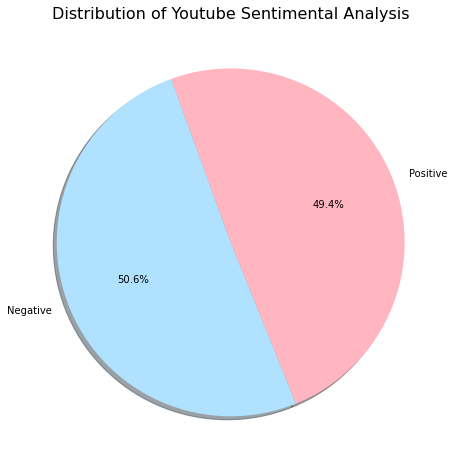

In [9]:
# Calculate the distribution for EmotionRoberta
emotionCounts = df['EmotionRoberta'].value_counts()
emotionCounts
# Plot a pie chart
plt.figure(figsize=(8, 8))
colors = ["#B0E2FF","#FFB6C1"]
labels = ['Negative','Positive']
# explode = (0.1, 0)  # explode 1st slice for better visibility
plt.pie(emotionCounts, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=110)
plt.title('Distribution of Youtube Sentimental Analysis',fontsize=16)
plt.show()


### Distribution of Predicted Category

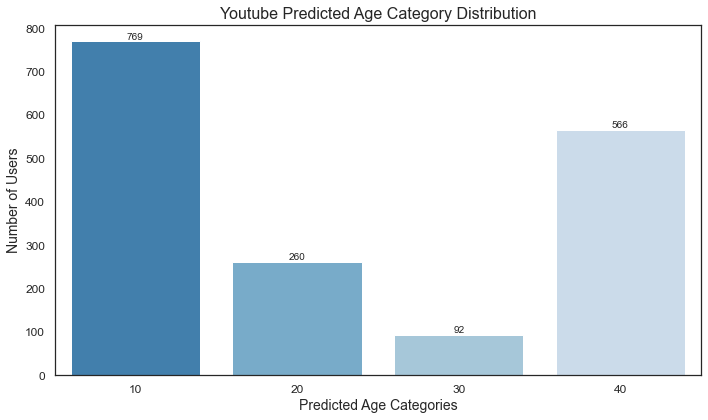

In [10]:
# Set seaborn style
sns.set(style="white")

# Count the occurrences of each predicted category
categoryCounts = df['PredictedCategory'].value_counts()


# Sort the category_counts Series by index
sortedCategory = categoryCounts.sort_index()

# Create a bar plot using seaborn with x-labels and y-values sorted
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sortedCategory.index, y=sortedCategory.values, palette="tab20c")


# Add labels and title
plt.xlabel('Predicted Age Categories', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.title('Youtube Predicted Age Category Distribution', fontsize=16)


# Rotate x labels for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add data labels on the bars
for index, value in enumerate(sortedCategory.values):
    plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


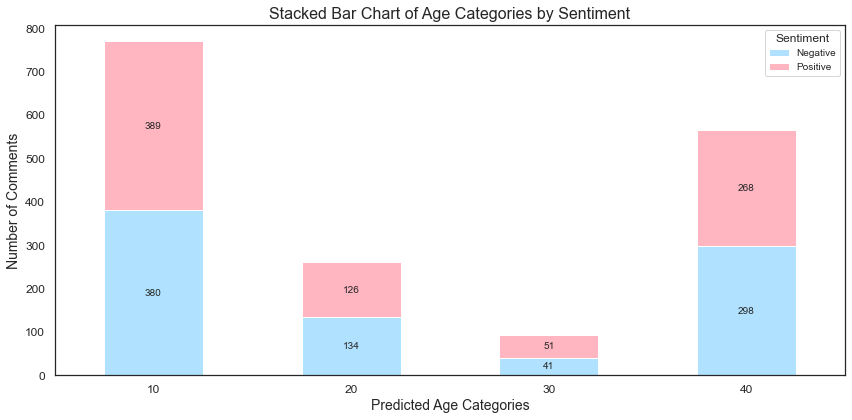

In [11]:
# Create a crosstab between PredictedCategory and EmotionRoberta
crosstabData= pd.crosstab(df['PredictedCategory'],df['EmotionRoberta'])

# Plot the stacked bar chart
ax = crosstabData.plot(kind='bar',stacked=True,figsize=(12, 6), color=["#B0E2FF","#FFB6C1"])

# Style and label the plot
plt.title('Stacked Bar Chart of Age Categories by Sentiment', fontsize=16)
plt.xlabel('Predicted Age Categories',fontsize=14)
plt.ylabel('Number of Comments',fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Sentiment', labels=['Negative', 'Positive'], fontsize=10)

# Add the emotion counts to the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # To avoid placing labels on bars with height 0
        ax.text(x + width/2, y + height/2, str(int(height)), ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Top 10 words for positive and negative comments 

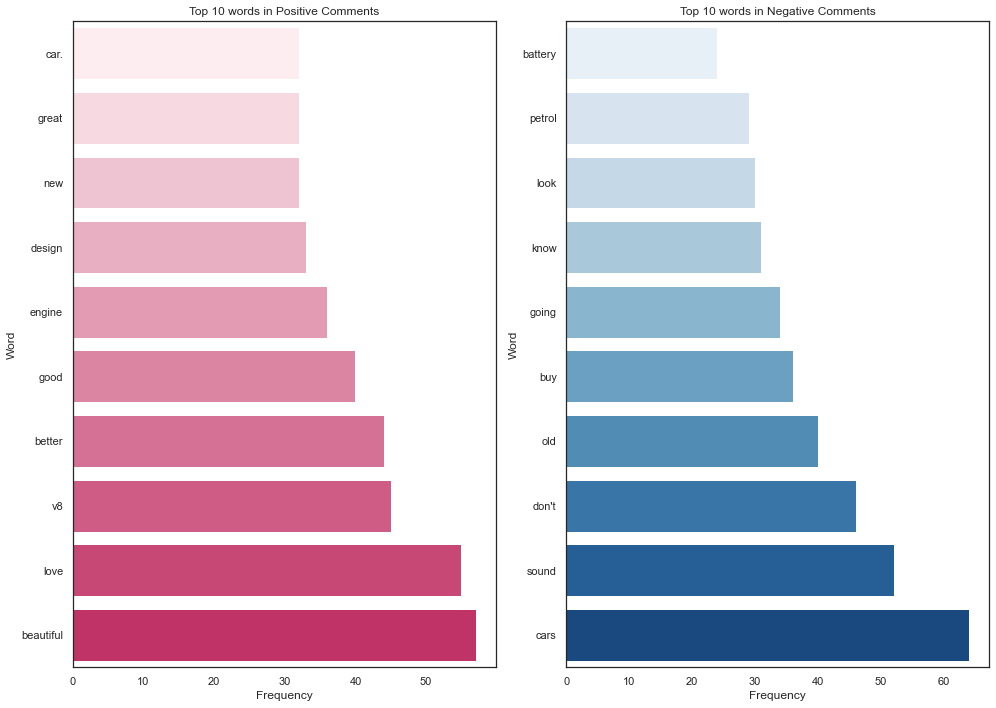

In [17]:
import seaborn as sns
import pandas as pd

# Convert the dictionaries to DataFrames
dfPositive = pd.DataFrame(finalPositiveCounts, columns=['Word', 'Frequency'])
dfNegative = pd.DataFrame(finalNegativeCounts, columns=['Word', 'Frequency'])

# Sort the data for better visualization
dfPositive = dfPositive.sort_values(by='Frequency')
dfNegative = dfNegative.sort_values(by='Frequency')

plt.figure(figsize=(14, 10))

pink_shades = sns.blend_palette(["#FFEBEE", "#D81B60"], n_colors=10)

# Plot for Positive Comments
plt.subplot(1, 2, 1)
sns.set_palette(pink_shades)

sns.barplot(data=dfPositive, y='Word', x='Frequency')
plt.title('Top 10 words in Positive Comments')

# Plot for Negative Comments
plt.subplot(1, 2, 2)
sns.barplot(data=dfNegative, y='Word', x='Frequency', palette="Blues")
plt.title('Top 10 words in Negative Comments')

plt.tight_layout()
plt.show()
